# Investigating the association between groundwater arsenic concentrations and water pH

----

## Background

Arsenic exposure through drinking water is a major public health concern. Over 200 million people worldwide are exposed to arsenic concentration in drinking exceeding the WHO guideline of 10 $\mu$g/L.<sup>1</sup>  Arsenic is a group 1 human carcinogen and exposure affects all organ systems.  Groundwater arsenic concentrations are influenced by pH: basic water nuetralizes soil ion exchange sites, therefore releasing arsenicals.<sup>2<sup>

<sup>1</sup> Naujokas, et al. Environ Health Perspect. 2013;121:295-302.
<sup>2</sup> https://umaine.edu/arsenic/how-does-arsenic-get-into-the-groundwater/

## Objective

The objective of this project is to investigate the association between groundwater arsenic concentrations and water pH in the United States.

## Overview of methods

* Datasets on sampling sites, water inorganic arsenic concentrations, and water pH were downloaded from the Nation Water Quality Monitoring Council at https://www.waterqualitydata.us/portal/
* Preliminary data cleaning was performed using Unix (e.g., removing unnecessary columns in the datasets).
* Using python, datasets were merged on location ID and month and year of sample collection.
* The association between water arsenic concentrtrations and pH were assessed using Pearson correlations and regression.
* Results were mapped using GeoMapApp.

## Jupyter Notebook contents
* This notebook cosists of the following main sections which can be accessed directly using the links:
  + [bash file to remove extra colmns from datasets](#bash_file)
  + [Opening data as pandas DataFrames](#open_dfs)
  + [Assessing arsenic concentrations](#inas_conc)
  + [Assessing pH](#ph)
  + [Combining arsenic and pH DataFrames](#inas_ph)
  + [Analysis of association between arsenic concentration and pH](#assoc)


## Summary of results

* Inorganic arsenic concentration and pH data matched on location, year, and month were only available for Oregon, and therefore analyses of association were restricted to this state.
* log(mean inorganic arsenic concentration) was positively associated with pH: $\rho$=0.60; *P*=2.314x10<sup>-06</sup>

<img align='left' src="oregon_map.png" width="500"/>

<img align='left' src="InAsReg.png" width="500"/>
----

## Code and results

---

## Loading python packages
---

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline  

<a id='bash_file'></a>

## bash file to remove extra colmns from datasets

```

#!/bin/sh

# Statation information dataset
# Looking at column names
head -n 1 result.csv 

# Removing extra columns (keeping only MonitoringLocationIdentifier, LatitudeMeasure, LongitudeMeasure, and StateCode)
cut -d , -f 3,12,13,26 station.csv > stationShort.csv

# Inorganic arsenic dataset
# Looking at column names
head -n 1 InAs.csv

# Removing extra columns (keeping only ActivityStartDate, MonitoringLocationIdentifier, ResultMeasureValue, ResultMeasure/MeasureUnitCode)
cut -d , -f 4,7,14,15 InAs.csv > InAsShort.csv

# pH dataset
# Looking at column names
head -n 1 ph.csv

# Removing extra columns (keeping only ActivityStartDate, MonitoringLocationIdentifier, ResultMeasureValue, ResultMeasure/MeasureUnitCode)
cut -d , -f 4,7,14,15 ph.csv > phShort.csv

# Saving as compressed file
tar -cvzf phShort.tar.gz phShort.csv phShort.csv

```

---

<a id='open_dfs'></a>

## Opening data as pandas DataFrames
---

#### Station dataset

In [9]:
stations = pd.read_csv('stationShort.csv', encoding = "ISO-8859-1")  # Specify encoding to avoid error
print(type(stations))
print(stations.shape)
stations.head()

<class 'pandas.core.frame.DataFrame'>
(112942, 4)


,MonitoringLocationIdentifier,LatitudeMeasure,LongitudeMeasure,StateCode
0,ARS-MDCR-MDCR_3001LTC,38.60267293,-76.1189339,24
1,ARS-MDCR-MDCR_3002LTC,NaN,NaN,NaN
2,NaN,NaN,NAD83,NaN
3,ARS-MDCR-MDCR_3003WC,NaN,NaN,NaN
4,NaN,NaN,NAD83,NaN


#### Arsenic dataset

In [10]:
dates = ['ActivityStartDate']
InAs = pd.read_csv('InAsShort.csv', encoding = "ISO-8859-1", parse_dates=dates)  # Specify encoding to avoid error
print(type(InAs))
print(InAs.shape)
InAs.head()

<class 'pandas.core.frame.DataFrame'>
(444, 4)


,ActivityStartDate,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode
0,1973-08-16,USGS-01614175,Total,NaN
1,1973-08-16,USGS-01638890,Total,NaN
2,1972-09-13,USGS-01555500,Total,0.0
3,1973-08-07,USGS-01555210,Total,NaN
4,1972-11-15,USGS-01533205,Total,NaN


#### pH dataset

#### bash file to unzip 

```

#!/bin/sh

gunzip phShort.tar.gz
tar -xvf phShort.tar

```

In [6]:
dtypes = {'ActivityStartDate':'str', 'MonitoringLocationIdentifier':'str', 'ResultMeasureValue':'str', 'ResultMeasure/MeasureUnitCode':'str'}
dates = ['ActivityStartDate']
ph = pd.read_csv('phShort.csv', dtype=dtypes, parse_dates=dates)
print(type(ph))
print(ph.shape)
ph.head()

<class 'pandas.core.frame.DataFrame'>
(1809729, 4)


,ActivityStartDate,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode
0,2012-08-21,USGS-07227500,8.0,std units
1,2013-10-21,USGS-07227500,8.2,std units
2,2014-08-05,USGS-07227500,8.2,std units
3,2014-08-05,USGS-07227500,8.2,std units
4,2012-03-20,USGS-07227500,8.6,std units


### Renaming columns and dropping NaN rows

In [11]:
stations = stations.rename(index=str, columns={"MonitoringLocationIdentifier":"locationID", "LatitudeMeasure":"lat", \
                                    "LongitudeMeasure": "lon", "StateCode":"state"})
stations = stations.dropna() 
print(stations.shape)
stations.head()

(98529, 4)


,locationID,lat,lon,state
0,ARS-MDCR-MDCR_3001LTC,38.60267293,-76.1189339,24
7,ARS-MDCR-MDCR_3005FC,38.81958292,-75.88143398,24
8,ARS-MDCR-MDCR_3006JC,38.82539292,-75.90349397,24
9,ARS-MDCR-MDCR_3007JC,38.85670291,-75.92216398,24
10,USGS-15011858,55.3880147,-130.3766943,2


In [12]:
InAs = InAs.rename(index=str, columns={"ActivityStartDate":"date","MonitoringLocationIdentifier":"locationID", \
                                       "ResultMeasureValue":"InAsMeas","ResultMeasure/MeasureUnitCode":"InAsVal"})
InAs = InAs.dropna() 
print(InAs.shape)
InAs.head()

(373, 4)


,date,locationID,InAsMeas,InAsVal
2,1972-09-13,USGS-01555500,Total,0.0
7,1972-11-09,USGS-01563500,Total,0.0
13,1972-10-02,USGS-01568200,Total,0.0
15,1973-09-18,USGS-01573610,Total,10
18,1972-11-10,USGS-01564995,Total,0.0


In [13]:
ph = ph.rename(index=str, columns={"ActivityStartDate":"date","MonitoringLocationIdentifier":"locationID", \
                                       "ResultMeasureValue":"phVal","ResultMeasure/MeasureUnitCode":"phMeas"})
ph = ph.dropna() 
print(ph.shape)
ph.head()

(1735873, 4)


,date,locationID,phVal,phMeas
0,2012-08-21,USGS-07227500,8.0,std units
1,2013-10-21,USGS-07227500,8.2,std units
2,2014-08-05,USGS-07227500,8.2,std units
3,2014-08-05,USGS-07227500,8.2,std units
4,2012-03-20,USGS-07227500,8.6,std units


<a id='inas_conc'></a>

## Assessing arsenic concentrations
---

### Merging InAs and station DataFrames.

In [14]:
# Setting column that is the index
stations.set_index('locationID') 
InAs.set_index('locationID')

# Extracting just month and year data for the InAs dataset
InAs['year'] = InAs['date'].dt.year
InAs['month'] = InAs['date'].dt.month

InAs.head()

,date,locationID,InAsMeas,InAsVal,year,month
2,1972-09-13,USGS-01555500,Total,0.0,1972,9
7,1972-11-09,USGS-01563500,Total,0.0,1972,11
13,1972-10-02,USGS-01568200,Total,0.0,1972,10
15,1973-09-18,USGS-01573610,Total,10,1973,9
18,1972-11-10,USGS-01564995,Total,0.0,1972,11


In [15]:
InAsStation = InAs.merge(stations, on='locationID')
print(InAsStation.shape)
InAsStation.head()

(359, 9)


,date,locationID,InAsMeas,InAsVal,year,month,lat,lon,state
0,1973-09-18,USGS-01573610,Total,10,1973,9,40.1912032,-76.7308027,42
1,2012-10-09,OREGONDEQ-24135-ORDEQ,Total,1.17,2012,10,44.79807255,-118.4725053,41
2,2012-10-09,OREGONDEQ-24135-ORDEQ,Total,1.2,2012,10,44.79807255,-118.4725053,41
3,2012-06-05,OREGONDEQ-33093-ORDEQ,Total,0.75,2012,6,44.3560024,-120.489612,41
4,2012-10-08,OREGONDEQ-37118-ORDEQ,Total,0.45,2012,10,44.835128,-119.0281881,41


### Writing DataFrame to csv

In [260]:
InAsStation.to_csv('InAsStation.csv')

### Summary of arsenic concentrations by state

* The majority of sampling locations are located in Oregon, with several located in Idaho, Pennsylvania, and Massachusetts.

### Mapping asenic concentrations in GeoMapApp

* InAsStation.csv imported to GeoMapApp.
* Point color set to InAs concentration values.
* State boundaries, rivers, and lakes/reservoirs added.

<img align='left' src="InAsOnly_map_leg2.png" width="800"/>


### Summary statistics of mean arsenic concentrations by state.

In [16]:
# Changing state codes to state names
# States coded according to the Federal Information Processing Standard state codes 
# https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code#FIPS_state_codes
InAsStation['state'].replace('16', 'Idaho', inplace=True)
InAsStation['state'].replace('25', 'Massachusetts', inplace=True)
InAsStation['state'].replace('41', 'Oregon', inplace=True)
InAsStation['state'].replace('42', 'Pennsylvania', inplace=True)

# Changing string arsenic concentrations to numeric
InAsStation['InAsVal'] = InAsStation['InAsVal'].convert_objects(convert_numeric=True) 

# Descriptive table
InAsStation['InAsVal'].groupby(InAsStation['state']).describe()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # Remove the CWD from sys.path while we load stuff.


,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
Idaho,5.0,1.353400,0.536281,0.707,0.9500,1.500,1.5400,2.070
Massachusetts,2.0,0.302000,0.094752,0.235,0.2685,0.302,0.3355,0.369
Oregon,343.0,3.429525,8.587797,0.030,0.2300,0.688,1.6200,62.300
Pennsylvania,1.0,10.000000,NaN,10.000,10.0000,10.000,10.0000,10.000
US,1.0,1.250000,NaN,1.250,1.2500,1.250,1.2500,1.250


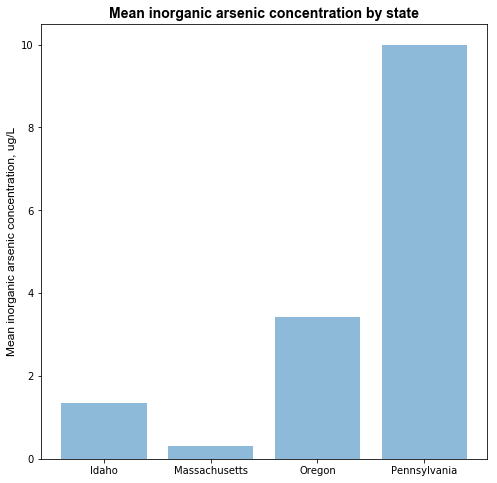

In [20]:
objects = ('Idaho', 'Massachusetts', 'Oregon', 'Pennsylvania')
y_pos = np.arange(len(objects))
means = [1.353400,0.302000,3.429525,10.000000]

font = {'family':'arial','color':'black','size': 12}
fontTitle = {'family':'arial','weight':'bold','color':'black','size': 14}

fig = plt.figure(figsize=(8,8))
plt.bar(y_pos, means, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Mean inorganic arsenic concentration, ug/L', fontdict=font)
plt.title('Mean inorganic arsenic concentration by state', fontdict=fontTitle)
 
plt.show()
fig.savefig('InAsbyState.pdf')

<a id='ph'></a>

## Assessing pH
---

### Merging pH and station DataFrames.

In [21]:
# Setting column that is the index
ph.set_index('locationID')

# Make non-dates into null
ph['date'] = pd.to_datetime(ph['date'], errors='coerce') 

# Extracting just month and year data for the InAs dataset
ph['year'] = ph['date'].dt.year
ph['month'] = ph['date'].dt.month

ph.head()

,date,locationID,phVal,phMeas,year,month
0,2012-08-21,USGS-07227500,8.0,std units,2012.0,8.0
1,2013-10-21,USGS-07227500,8.2,std units,2013.0,10.0
2,2014-08-05,USGS-07227500,8.2,std units,2014.0,8.0
3,2014-08-05,USGS-07227500,8.2,std units,2014.0,8.0
4,2012-03-20,USGS-07227500,8.6,std units,2012.0,3.0


In [22]:
phStation = ph.merge(stations, on='locationID')
print(phStation.shape)
phStation.head()

(328007, 9)


,date,locationID,phVal,phMeas,year,month,lat,lon,state
0,2012-08-21,USGS-07227500,8.0,std units,2012.0,8.0,sq mi,35.4703261,US
1,2013-10-21,USGS-07227500,8.2,std units,2013.0,10.0,sq mi,35.4703261,US
2,2014-08-05,USGS-07227500,8.2,std units,2014.0,8.0,sq mi,35.4703261,US
3,2014-08-05,USGS-07227500,8.2,std units,2014.0,8.0,sq mi,35.4703261,US
4,2012-03-20,USGS-07227500,8.6,std units,2012.0,3.0,sq mi,35.4703261,US


### Writing DataFrame to csv

In [300]:
phStation.to_csv('phStation.csv')

### Summary of arsenic concentrations

### Mapping pH in GeoMapApp

* phStation.csv imported to GeoMapApp.
* Point color set to pH values.

<img align='left' src="phOnlyWorld_map_leg.png" width="900"/>

### Limiting data to US

* pH dataset contains sample sites outside of the US, therefore removing datapoints not included in latitude and longitudes bounding the US.

In [23]:
# Changing string latitudes and longitudes to numeric
phStation['lat'] = phStation['lat'].convert_objects(convert_numeric=True) 
phStation['lon'] = phStation['lon'].convert_objects(convert_numeric=True) 

# Limiting to latitudes 15 through 71 and longitudes -178 through -60
phStationsUS = phStation.loc[(phStation['lat'] > 15) & (phStation['lat'] < 71) & (phStation['lon'] > -178) \
                           & (phStation['lon'] < -60)]

phStationsUS.shape

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


(303457, 9)

### Writing DataFrame to csv

In [306]:
phStationsUS.to_csv('phStationUS.csv')

### Mapping pH in US in GeoMapApp

* phStationUS.csv imported to GeoMapApp.
* Point color set to pH values.
* State boundaries, rivers, and lakes/reservoirs added.

<img align='left' src="phOnlyUS_map_leg.png" width="900"/>

### Summary statistics of mean pH by state.

In [27]:
# Changing string arsenic concentrations to numeric
phStationsUS['phVal'] = phStationsUS['phVal'].convert_objects(convert_numeric=True) 

# Descriptive table
phSumm = phStationsUS['phVal'].groupby(phStationsUS['state']).describe()

# Renaming rows as state names based on FIPs codes
rows = list(phSumm.index)
rowsNew = rows
import us
for i in range(len(rows)):
    rowsNew[i] = us.states.lookup(rows[i])

rowsNew

rowsRename = dict(zip(phSumm.index, rowsNew))

phSumm = phSumm.rename(rowsRename)

phSummNew = phSumm.drop(phSumm.index[0]) # Dropping rows not associated with a state name
phSummNew

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
Delaware,2054.0,7.330214,0.636434,5.230000,6.890000,7.310000,7.770000,9.66
District of Columbia,3902.0,7.764256,0.479682,6.488481,7.420000,7.782320,8.100000,10.04
Florida,39630.0,7.481511,3.554875,-89.300000,7.200000,7.520000,7.900000,689.00
Georgia,2677.0,6.893365,0.819016,3.560000,6.340000,6.920000,7.440000,9.19
Idaho,3256.0,7.125055,0.887208,2.240000,6.600000,7.200000,7.770000,10.20
Illinois,3003.0,8.233200,14.916251,5.050000,7.700000,7.970000,8.240000,822.00
Indiana,7.0,8.688571,0.466098,8.080000,8.395000,8.730000,8.855000,9.51
Iowa,2592.0,8.172670,0.433520,6.100000,7.900000,8.200000,8.400000,10.00
Kansas,995.0,7.788001,0.415161,6.500000,7.600000,7.800000,8.005000,9.87


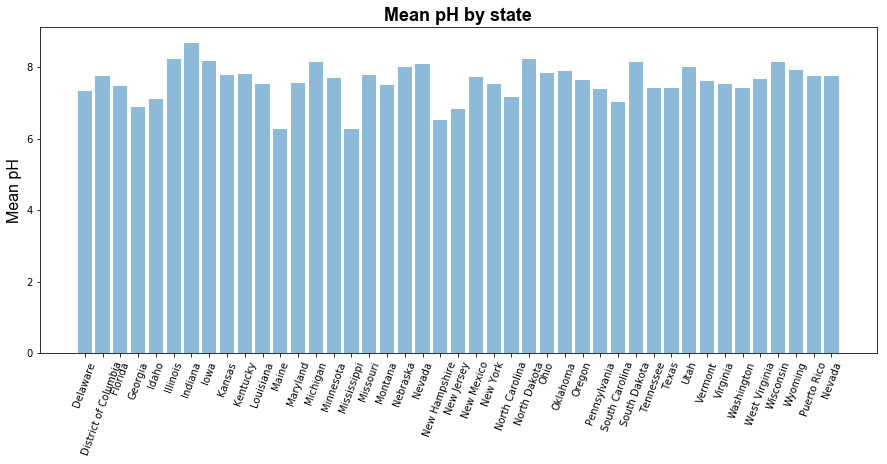

In [31]:
objects = list(phSummNew.index)
means = phSummNew['mean']
y_pos = np.arange(len(objects))

font = {'family':'arial','color':'black','size': 16}
fontTitle = {'family':'arial','weight':'bold','color':'black','size': 18}

fig = plt.figure(figsize=(15,6))
plt.bar(y_pos, means, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=70)
plt.ylabel('Mean pH', fontdict=font)
plt.title('Mean pH by state', fontdict=fontTitle)

fig.savefig('pHbyState.pdf')

<a id='inas_ph'></a>

## Combining arsenic and pH DataFrames
---

In [32]:
# Merging on location, year, and month
dataMerge = InAsStation.merge(phStationsUS, on=['locationID', 'year', 'month'])
print(dataMerge.shape)
dataMerge.head()

(103, 15)


,date_x,locationID,InAsMeas,InAsVal,year,month,lat_x,lon_x,state_x,date_y,phVal,phMeas,lat_y,lon_y,state_y
0,2012-10-09,OREGONDEQ-24135-ORDEQ,Total,1.17,2012,10,44.79807255,-118.4725053,Oregon,2012-10-09,8.1,None,44.798073,-118.472505,41
1,2012-10-09,OREGONDEQ-24135-ORDEQ,Total,1.17,2012,10,44.79807255,-118.4725053,Oregon,2012-10-09,8.1,None,44.798073,-118.472505,41
2,2012-10-09,OREGONDEQ-24135-ORDEQ,Total,1.20,2012,10,44.79807255,-118.4725053,Oregon,2012-10-09,8.1,None,44.798073,-118.472505,41
3,2012-10-09,OREGONDEQ-24135-ORDEQ,Total,1.20,2012,10,44.79807255,-118.4725053,Oregon,2012-10-09,8.1,None,44.798073,-118.472505,41
4,2012-06-05,OREGONDEQ-33093-ORDEQ,Total,0.75,2012,6,44.3560024,-120.489612,Oregon,2012-06-05,8.1,None,44.356002,-120.489612,41


In [33]:
# Dropping extra latitude, longitude, and date columns
dataMerge.drop('lat_x', axis=1, inplace=True)
dataMerge.drop('lon_x', axis=1, inplace=True)
dataMerge.drop('date_y', axis=1, inplace=True)

# Renaming columns
dataMerge = dataMerge.rename(columns={'date_x': 'date', 'lat_y': 'lat', 'lon_y': 'lon'})

dataMerge.head()

,date,locationID,InAsMeas,InAsVal,year,month,state_x,phVal,phMeas,lat,lon,state_y
0,2012-10-09,OREGONDEQ-24135-ORDEQ,Total,1.17,2012,10,Oregon,8.1,None,44.798073,-118.472505,41
1,2012-10-09,OREGONDEQ-24135-ORDEQ,Total,1.17,2012,10,Oregon,8.1,None,44.798073,-118.472505,41
2,2012-10-09,OREGONDEQ-24135-ORDEQ,Total,1.20,2012,10,Oregon,8.1,None,44.798073,-118.472505,41
3,2012-10-09,OREGONDEQ-24135-ORDEQ,Total,1.20,2012,10,Oregon,8.1,None,44.798073,-118.472505,41
4,2012-06-05,OREGONDEQ-33093-ORDEQ,Total,0.75,2012,6,Oregon,8.1,None,44.356002,-120.489612,41


### Looking at number of observations per location

* After merging, there are only sites in Oregon with arsenic concentrations and pH measured in the same year and month.

In [34]:
# Number of observations per location, year, and month
pd.crosstab(dataMerge.locationID, [dataMerge.year, dataMerge.month])

year                  2012          2013    2014          2015                 \
month                   5  6  10 11   9  11   7  8  9  10   1  5  6  7  8  9    
locationID                                                                      
OREGONDEQ-10391-ORDEQ    0  0  0  0    1  1    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-10404-ORDEQ    0  0  0  0    0  0    0  1  0  0    0  0  0  0  0  0   
OREGONDEQ-10411-ORDEQ    0  1  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-10443-ORDEQ    0  0  0  0    0  0    0  0  0  0    0  0  0  1  0  0   
OREGONDEQ-10506-ORDEQ    0  1  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-10508-ORDEQ    0  4  4  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-10517-ORDEQ    0  0  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-10674-ORDEQ    0  0  0  1    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-10684-ORDEQ    0  1  2  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-10689-ORDEQ    0  1  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-10696-ORDEQ    0  4  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-10697-ORDEQ    0  1  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-10724-ORDEQ    0  0  0  0    0  0    0  0  0  0    0  0  0  0  1  0   
OREGONDEQ-10763-ORDEQ    0  0  0  0    0  0    0  0  0  0    0  1  0  0  0  0   
OREGONDEQ-10768-ORDEQ    0  0  0  0    0  0    0  0  2  0    1  0  0  0  0  1   
OREGONDEQ-10996-ORDEQ    0  0  0  0    0  0    1  0  0  0    0  0  0  0  0  0   
OREGONDEQ-11016-ORDEQ    0  0  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-11020-ORDEQ    0  0  2  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-11025-ORDEQ    0  0  0  1    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-11201-ORDEQ    0  0  0  0    0  0    0  0  0  0    0  0  0  0  1  0   
OREGONDEQ-11386-ORDEQ    0  0  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-11387-ORDEQ    0  1  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-11477-ORDEQ    0  2  0  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-11478-ORDEQ    0  0  4  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-11972-ORDEQ    2  0  0  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-12561-ORDEQ    0  0  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-13070-ORDEQ    0  0  0  0    0  0    0  0  0  2    0  0  1  0  0  0   
OREGONDEQ-13138-ORDEQ    1  0  0  4    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-13139-ORDEQ    0  0  0  1    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-13140-ORDEQ    0  0  0  1    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-13148-ORDEQ    1  0  0  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-13253-ORDEQ    1  0  0  2    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-20434-ORDEQ    0  0  0  0    0  2    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-22985-ORDEQ    0  0  0  0    0  0    0  2  0  0    0  0  0  0  0  0   
OREGONDEQ-24135-ORDEQ    0  0  4  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-26419-ORDEQ    0  0  0  1    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-31987-ORDEQ    0  0  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-31990-ORDEQ    0  0  1  0    0  0    0  0  0  0    0  0  0  0  2  0   
OREGONDEQ-32494-ORDEQ    0  1  0  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-33093-ORDEQ    0  1  0  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-33929-ORDEQ    0  0  0  0    0  0    0  0  2  0    0  0  0  0  0  0   
OREGONDEQ-33939-ORDEQ    0  0  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-34102-ORDEQ    0  0  0  1    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-34115-ORDEQ    0  0  0  0    1  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-36030-ORDEQ    0  0  1  0    0  0    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-36432-ORDEQ    0  0  0  0    0  1    0  0  0  0    0  0  0  0  0  0   
OREGONDEQ-36776-ORDEQ    0  1  

### Averaging observations if there are two or more for a location

In [35]:
dataMerge = dataMerge.dropna() 

# Calculating mean arsenic concentrations
InAsMean = dataMerge.groupby('locationID', as_index=False)['InAsVal'].mean()
print(InAsMean.head())

# Calculating mean pH
phMean = dataMerge.groupby('locationID', as_index=False)['phVal'].mean()
print(phMean.head())

              locationID  InAsVal
0  OREGONDEQ-10391-ORDEQ    0.081
1  OREGONDEQ-10404-ORDEQ    0.143
2  OREGONDEQ-10411-ORDEQ    0.965
3  OREGONDEQ-10443-ORDEQ    0.470
4  OREGONDEQ-10506-ORDEQ    0.900
              locationID  phVal
0  OREGONDEQ-10391-ORDEQ   7.69
1  OREGONDEQ-10404-ORDEQ   8.69
2  OREGONDEQ-10411-ORDEQ   8.25
3  OREGONDEQ-10443-ORDEQ   8.80
4  OREGONDEQ-10506-ORDEQ   8.85


In [36]:
# Merging mean arsenic concentrations and pHs into a single dataset
dataMean = InAsMean.merge(phMean, on=['locationID'])
dataMean = dataMean.merge(stations, on='locationID')

dataMean.to_csv('dataMean.csv') # Saving dataset as csv

dataMean.head()

,locationID,InAsVal,phVal,lat,lon,state
0,OREGONDEQ-10391-ORDEQ,0.081,7.69,44.76428368,-123.91502,41
1,OREGONDEQ-10404-ORDEQ,0.143,8.69,45.67731022,-119.0363477,41
2,OREGONDEQ-10411-ORDEQ,0.965,8.25,45.63251478,-120.9125077,41
3,OREGONDEQ-10443-ORDEQ,0.470,8.80,43.13391838,-123.3992438,41
4,OREGONDEQ-10506-ORDEQ,0.900,8.85,44.76138,-121.2286117,41


<a id='assoc'></a>

## Analysis of association between arsenic concentration and pH

---

### Mapping arsenic concentrations and pH

* csv file opened in GeoMapApp
* Sampling locaitons plotted by latitutde and longitude
* Points scaled by pH
* Points colored by InAs concentration

<img align='left' src="oregon_map.png" width="900"/>

### Assessing distribution of arsenic concentration

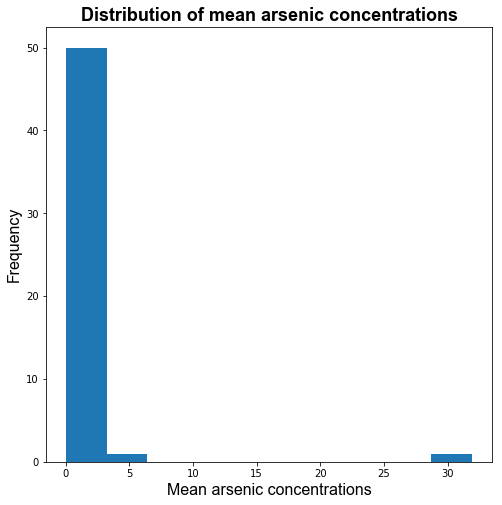

In [38]:
font = {'family':'arial','color':'black','size': 16}
fontTitle = {'family':'arial','weight':'bold','color':'black','size': 18}

fig = plt.figure(figsize=(8,8))
plt.hist(dataMean.InAsVal)
plt.title("Distribution of mean arsenic concentrations", fontdict=fontTitle)
plt.xlabel("Mean arsenic concentrations", fontdict=font)
plt.ylabel("Frequency", fontdict=font)

fig.savefig('InAsHist.pdf')

In [40]:
# Arsenic concentrations are not normally distributed, therefore log-transforming arsenic
dataMean['InAsValLog'] = np.log(dataMean['InAsVal'])
dataMean.head()

,locationID,InAsVal,phVal,lat,lon,state,InAsValLog
0,OREGONDEQ-10391-ORDEQ,0.081,7.69,44.76428368,-123.91502,41,-2.513306
1,OREGONDEQ-10404-ORDEQ,0.143,8.69,45.67731022,-119.0363477,41,-1.944911
2,OREGONDEQ-10411-ORDEQ,0.965,8.25,45.63251478,-120.9125077,41,-0.035627
3,OREGONDEQ-10443-ORDEQ,0.470,8.80,43.13391838,-123.3992438,41,-0.755023
4,OREGONDEQ-10506-ORDEQ,0.900,8.85,44.76138,-121.2286117,41,-0.105361


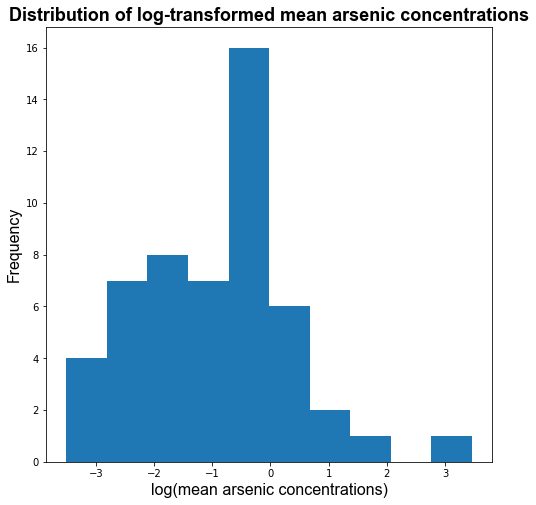

In [41]:
font = {'family':'arial','color':'black','size': 16}
fontTitle = {'family':'arial','weight':'bold','color':'black','size': 18}

fig = plt.figure(figsize=(8,8))
plt.hist(dataMean.InAsValLog)
plt.title("Distribution of log-transformed mean arsenic concentrations", fontdict=fontTitle)
plt.xlabel("log(mean arsenic concentrations)", fontdict=font)
plt.ylabel("Frequency", fontdict=font)

fig.savefig('InAsHistLog.pdf')

### Assessing correlation between arsenic concentration and pH

In [115]:
# Pearson correlation and significance
from scipy import stats
stats.pearsonr(dataMean.phVal, dataMean.InAsValLog)

(0.60229809023598724, 2.3139784442554846e-06)

* Log-transformed mean arsenic concentration is positively correlated with pH: 
  + $\rho$=0.60
  + *P*=2.314x10<sup>-06</sup>

In [119]:
# Linear regression
from scipy.stats import linregress
linregress(dataMean.phVal, dataMean.InAsValLog)

LinregressResult(slope=1.5977288045432851, intercept=-13.680144854763295, rvalue=0.60229809023598713, pvalue=2.3139784442554964e-06, stderr=0.2994725857051691)

* In a linear regression model log-transformed mean arsenic concentration is positively associated with pH:
  + Slope=1.60
  + Intercept: -13.68
  + *P*=2.314x10<sup>-06</sup>

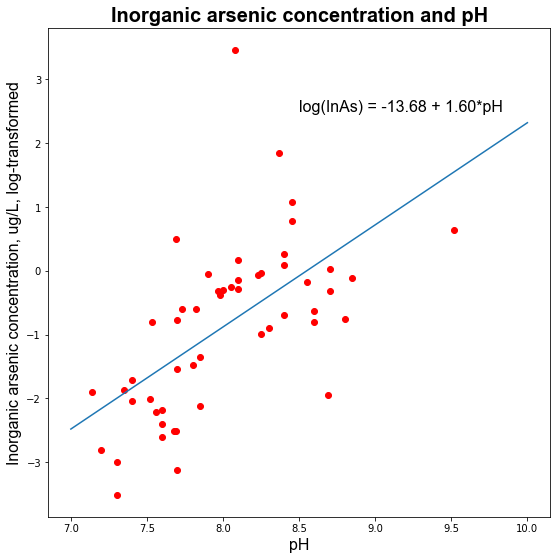

In [159]:
# Plotting InAs and pH values
def graph(formula):  
    x = np.array(range(7,11))  
    y = formula(x)  # <- note now we're calling the function 'formula' with x
    plt.plot(x, y)  
    plt.show()  

def regResult(x):
    return -13.68+(1.60*x)

font = {'family':'arial','color':'black','size': 16}
fontTitle = {'family':'arial','weight':'bold','color':'black','size': 20}

fig = plt.figure(figsize=(9,9))
plt.plot(dataMean.phVal, dataMean.InAsValLog, 'ro')
plt.xlabel('pH', fontdict=font)
plt.ylabel('Inorganic arsenic concentration, ug/L, log-transformed', fontdict=font)
plt.title('Inorganic arsenic concentration and pH', fontdict=fontTitle)
plt.text(8.5, 2.5, 'log(InAs) = -13.68 + 1.60*pH', fontdict=font)
graph(regResult)
fig.savefig('InAsReg.pdf')
fig.savefig('InAsReg2.png')